In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Bibliotecas

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pickle
import unicodedata
import regex
import urllib
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from time import sleep
from os import listdir
from os.path import isdir
from PIL import ImageChops,Image
from tqdm import tqdm
from scipy.spatial import distance

from sklearn.metrics import mean_squared_error,confusion_matrix
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
!pip install sewar
from sewar.full_ref import uqi, scc, sam, vifp
!pip install xgboost
import xgboost as xgb
!pip install optuna
import optuna
!pip install lightgbm
import lightgbm as lgb

## Carregando o dataset
###### o caminho abaixo é referente a alguns testes que realizei na minha máquina local

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/data_set_meliuz/Cópia de train.csv')
#train = pd.read_csv(r'C:/Users/U11029/Downloads/Cópia de train.csv')

In [ ]:
len(train)

410

In [ ]:
train.head()

,id_1,id_2,title_1,title_2,price_1,price_2,image_1,image_2,matching
0,3047e40c57022c60c0663d017521415c,d7790211e8b5091b6d9b0dda4da3c0a0,Smartphone K22 LMK200BMW Android 10 32gb 13mp 6.2,Smartphone LG K22 Dual Chip Android 10 Tela 6.2,899,759,https://i.zst.com.br/thumbs/8/38/13/1260212008...,https://i.zst.com.br/thumbs/8/39/d/1179261696.jpg,1
1,6e78cc6231c7ed05e1de0a6091f5e64f,7e9a2e8e9f78d9700bc65c64ed0564e3,iPhone SE 64GB - (PRODUCT)RED,"iPhone SE Apple 64GB (PRODUCT)RED, Tela Retina...",3699,2999,https://i.zst.com.br/thumbs/8/11/1b/1261616805...,https://i.zst.com.br/thumbs/8/5/14/1260796278.jpg,1
2,12844b6ad6668633bfbf4ce62c1f5077,25f8618b1dc42722715e65a2d4f9a2bc,Smartphone Sony Xperia Z5 Premium Ouro com 32G...,Smartphone Sony Xperia Z5 Premium 32GB 3GB RAM...,1672,1672,https://i.zst.com.br/thumbs/8/indsp.gif,https://i.zst.com.br/thumbs/8/2c/34/1177004426...,1
3,71d0d1f8b61cd22a45d94f7eff9f26a1,683eb31fde3f9cdba333c730433247d9,"Smartphone Multilaser MS60F, Quad Core, Androi...","Smartphone Ms60F 4G Tela 5,5 Sensor De Impress...",399,479,https://i.zst.com.br/thumbs/8/21/14/741730944.jpg,https://i.zst.com.br/thumbs/8/31/e/1099790410.jpg,1
4,47c56cecca087249f2010785eeef3468,a58daf4b62786a9008fc8ef4fca26325,Usado: Samsung Galaxy S8 Plus 64GB Prata Excel...,Usado: Samsung Galaxy S8 Plus 64GB Preto Excel...,1329,1329,https://i.zst.com.br/thumbs/8/29/d/830261504.jpg,https://i.zst.com.br/thumbs/8/27/1a/1150934304...,1


In [ ]:
train.drop(['id_1', 'id_2'], axis=1,inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title_1   410 non-null    object
 1   title_2   410 non-null    object
 2   price_1   410 non-null    int64 
 3   price_2   410 non-null    int64 
 4   image_1   410 non-null    object
 5   image_2   410 non-null    object
 6   matching  410 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 22.5+ KB


### Definindo algumas funções especiais

In [ ]:
def levenshtein_ratio_and_distance(s, t, ratio_calc = False):
    '''
    https://www.datacamp.com/community/tutorials/fuzzy-string-python
    '''
    """ levenshtein_ratio_and_distance:
        Calculates levenshtein distance between two strings.
        If ratio_calc = True, the function computes the
        levenshtein distance ratio of similarity between two strings
        For all i and j, distance[i,j] will contain the Levenshtein
        distance between the first i characters of s and the
        first j characters of t
    """
    # Initialize matrix of zeros
    rows = len(s)+1
    cols = len(t)+1
    distance = np.zeros((rows,cols),dtype = int)

    # Populate matrix of zeros with the indeces of each character of both strings
    for i in range(1, rows):
        for k in range(1,cols):
            distance[i][0] = i
            distance[0][k] = k

    # Iterate over the matrix to compute the cost of deletions,insertions and/or substitutions    
    for col in range(1, cols):
        for row in range(1, rows):
            if s[row-1] == t[col-1]:
                cost = 0 # If the characters are the same in the two strings in a given position [i,j] then the cost is 0
            else:
                # In order to align the results with those of the Python Levenshtein package, if we choose to calculate the ratio
                # the cost of a substitution is 2. If we calculate just distance, then the cost of a substitution is 1.
                if ratio_calc == True:
                    cost = 2
                else:
                    cost = 1
            distance[row][col] = min(distance[row-1][col] + 1,      # Cost of deletions
                                 distance[row][col-1] + 1,          # Cost of insertions
                                 distance[row-1][col-1] + cost)     # Cost of substitutions
    if ratio_calc == True:
        # Computation of the Levenshtein Distance Ratio
        Ratio = ((len(s)+len(t)) - distance[row][col]) / (len(s)+len(t))
        return Ratio
    else:
        # print(distance) # Uncomment if you want to see the matrix showing how the algorithm computes the cost of deletions,
        # insertions and/or substitutions
        # This is the minimum number of edits needed to convert string a to string b
        return "The strings are {} edits away".format(distance[row][col])

In [ ]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)if unicodedata.category(c) != 'Mn')

In [ ]:
def remove_non_latin(text):
    encoded_string = text.encode("ascii", "ignore")
    decode_string = encoded_string.decode()
    return decode_string

## Gerando métricas de análise de similaridade de texto e adicionando-as ao dataset

In [ ]:
# Títulos
l_puro = []
l_ratio = []
l_token = []
l_pr = []
for linha in tqdm(range(len(train))):
    t1 = str(train['title_1'][linha]).replace('Usado:','').replace('Desbloqueado','').replace(',','').replace('(PRODUCT)','').replace('- Trocafone','').replace('Celular','').replace('Smartphone','').replace('.','').replace(' ','').lower()
    t1 = strip_accents(t1)
    t1 = remove_non_latin(t1)
    
    t2 = str(train['title_2'][linha]).replace('Usado:','').replace('Desbloqueado','').replace(',','').replace('(PRODUCT)','').replace('- Trocafone','').replace('Celular','').replace('Smartphone','').replace('.','').replace(' ','').lower()
    t2 = strip_accents(t2)
    t2 = remove_non_latin(t2)
    # print('--->>>SIMILARIDADE:',similaridade,'\n',t1,'\n',t2,'\n')

    # Hamming Distance
    # não é proveitoso pois as strings precisam ser principalmente do mesmo tamanho
    # similaridade = distance.hamming(list(t1),list(t2))

    # levenshtein puro
    l_puro.append(levenshtein_ratio_and_distance(t1,t2,ratio_calc = True))

    # igual a levenshtein, mas com menos casas decimais, pois é da lib fuzzywuzzy
    l_ratio.append(fuzz.ratio(t1,t2)/100)

    # Lida com casos em que as palavras estejam
    # em ordens diferentes, ele não será afetado
    l_token.append(fuzz.token_sort_ratio(t1,t2)/100)

    # Lida melhor pois considera substrings, ou seja, não é vítima de string de 
    # tamnhos muito divergentes
    l_pr.append(fuzz.partial_ratio(t1,t2)/100 )

100%|██████████| 410/410 [00:04<00:00, 97.74it/s] 


In [ ]:
train['t_s_f_puro'] = l_puro
train['t_s_f_ratio'] = l_ratio
train['t_s_f_token'] = l_token
train['t_s_f_pr'] = l_pr

In [ ]:
train.head()

,title_1,title_2,price_1,price_2,image_1,image_2,matching,t_s_f_puro,t_s_f_ratio,t_s_f_token,t_s_f_pr
0,Smartphone K22 LMK200BMW Android 10 32gb 13mp 6.2,Smartphone LG K22 Dual Chip Android 10 Tela 6.2,899,759,https://i.zst.com.br/thumbs/8/38/13/1260212008...,https://i.zst.com.br/thumbs/8/39/d/1179261696.jpg,1,0.508475,0.51,0.51,0.50
1,iPhone SE 64GB - (PRODUCT)RED,"iPhone SE Apple 64GB (PRODUCT)RED, Tela Retina...",3699,2999,https://i.zst.com.br/thumbs/8/11/1b/1261616805...,https://i.zst.com.br/thumbs/8/5/14/1260796278.jpg,1,0.365854,0.37,0.37,0.69
2,Smartphone Sony Xperia Z5 Premium Ouro com 32G...,Smartphone Sony Xperia Z5 Premium 32GB 3GB RAM...,1672,1672,https://i.zst.com.br/thumbs/8/indsp.gif,https://i.zst.com.br/thumbs/8/2c/34/1177004426...,1,0.616667,0.48,0.48,0.66
3,"Smartphone Multilaser MS60F, Quad Core, Androi...","Smartphone Ms60F 4G Tela 5,5 Sensor De Impress...",399,479,https://i.zst.com.br/thumbs/8/21/14/741730944.jpg,https://i.zst.com.br/thumbs/8/31/e/1099790410.jpg,1,0.460526,0.25,0.25,0.41
4,Usado: Samsung Galaxy S8 Plus 64GB Prata Excel...,Usado: Samsung Galaxy S8 Plus 64GB Preto Excel...,1329,1329,https://i.zst.com.br/thumbs/8/29/d/830261504.jpg,https://i.zst.com.br/thumbs/8/27/1a/1150934304...,1,0.945946,0.95,0.95,0.95


Index(['matching', 't_s_f_puro', 't_s_f_ratio', 't_s_f_token', 't_s_f_pr'], dtype='object')


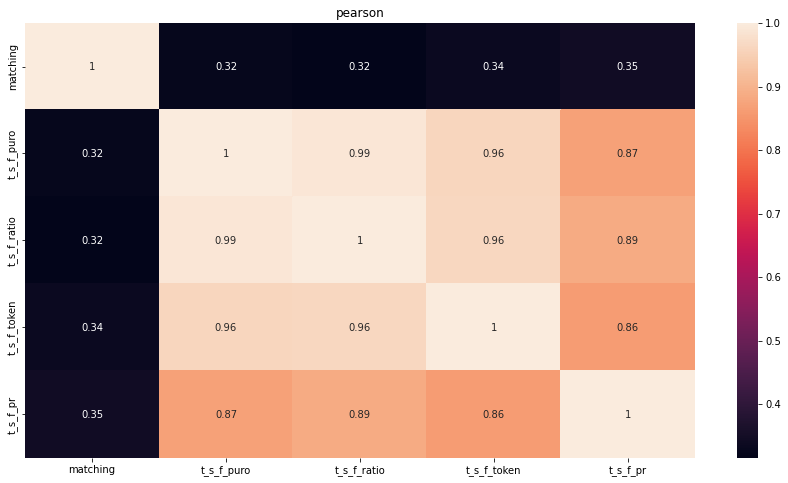

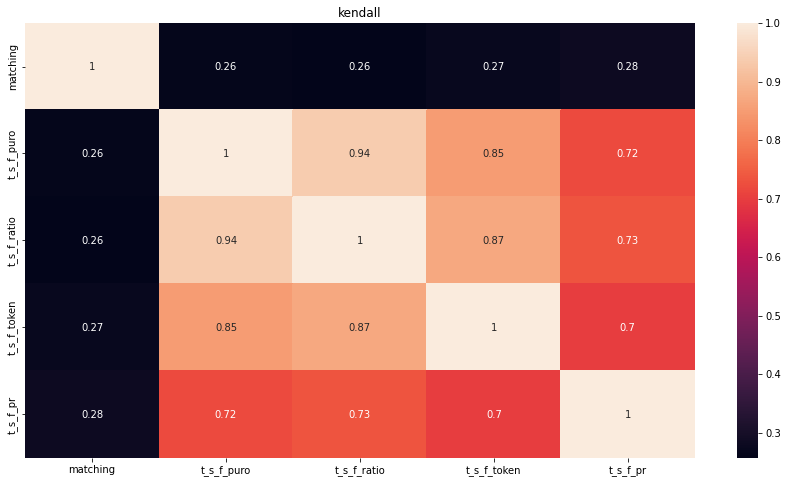

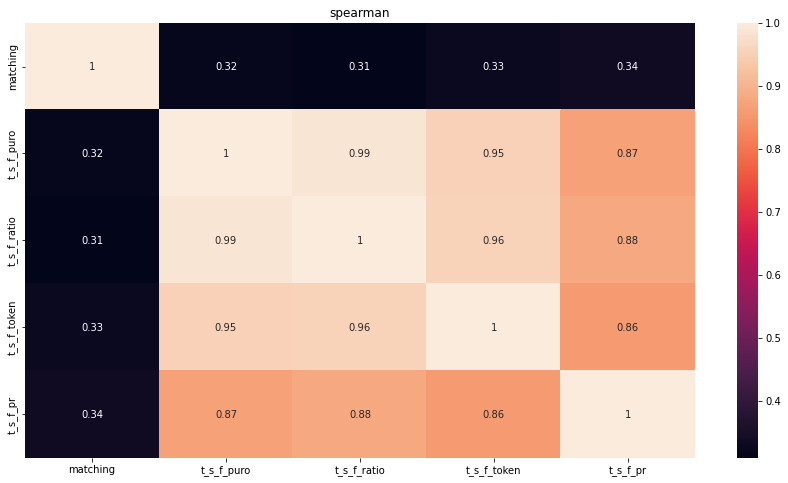

In [ ]:
metodos = {'l_puro':l_puro,'l_ratio':l_ratio,'l_token':l_token,'l_pr':l_pr}
train_correlation = train.drop(['title_1','title_2','price_1','price_2','image_1','image_2'], axis=1)
print(train_correlation.columns)
#matriz de correlação
for metodo in ['pearson','kendall','spearman']:
    cor = train_correlation.corr(method=metodo)
    plt.figure(figsize = (15,8))
    plt.title(metodo)
    sns.heatmap(cor, annot = True)

## Gerando métricas de análise de similaridade de preço e adicionando-as ao dataset

#### Para termos uma taxa entre 0 e 1, sempre será dividido o menor pelo maior. Caso não seja possível realizar esta divisão, coloca-se um "meio termo", 0.5.
#### Caso haja casos sem valor, é flagado como 0 no campo 'tem_valor'.

In [ ]:
# Preços
similaridade_valor = []
tem_valor = []
for linha in tqdm(range(len(train))):
    v1 = train['price_1'][linha]
    v2 = train['price_2'][linha]
    if v1 == 0 or v2 == 0:
        tem_valor.append(0)
    else:
        tem_valor.append(1)
    if v1>=v2:
        similaridade = v2/v1
    elif v1<=v2:
        similaridade = v1/v2 
    else:
        similaridade = 0.5
    similaridade_valor.append(similaridade)
    #print('--->>>SIMILARIDADE:',similaridade,'\n',v1,'\n',v2,'\n')
train['simi_valor'] = similaridade_valor
train['tem_valor'] = tem_valor

100%|██████████| 410/410 [00:00<00:00, 38601.64it/s]


In [ ]:
train.head()

,title_1,title_2,price_1,price_2,image_1,image_2,matching,t_s_f_puro,t_s_f_ratio,t_s_f_token,t_s_f_pr,simi_valor,tem_valor
0,Smartphone K22 LMK200BMW Android 10 32gb 13mp 6.2,Smartphone LG K22 Dual Chip Android 10 Tela 6.2,899,759,https://i.zst.com.br/thumbs/8/38/13/1260212008...,https://i.zst.com.br/thumbs/8/39/d/1179261696.jpg,1,0.508475,0.51,0.51,0.50,0.844271,1
1,iPhone SE 64GB - (PRODUCT)RED,"iPhone SE Apple 64GB (PRODUCT)RED, Tela Retina...",3699,2999,https://i.zst.com.br/thumbs/8/11/1b/1261616805...,https://i.zst.com.br/thumbs/8/5/14/1260796278.jpg,1,0.365854,0.37,0.37,0.69,0.810760,1
2,Smartphone Sony Xperia Z5 Premium Ouro com 32G...,Smartphone Sony Xperia Z5 Premium 32GB 3GB RAM...,1672,1672,https://i.zst.com.br/thumbs/8/indsp.gif,https://i.zst.com.br/thumbs/8/2c/34/1177004426...,1,0.616667,0.48,0.48,0.66,1.000000,1
3,"Smartphone Multilaser MS60F, Quad Core, Androi...","Smartphone Ms60F 4G Tela 5,5 Sensor De Impress...",399,479,https://i.zst.com.br/thumbs/8/21/14/741730944.jpg,https://i.zst.com.br/thumbs/8/31/e/1099790410.jpg,1,0.460526,0.25,0.25,0.41,0.832985,1
4,Usado: Samsung Galaxy S8 Plus 64GB Prata Excel...,Usado: Samsung Galaxy S8 Plus 64GB Preto Excel...,1329,1329,https://i.zst.com.br/thumbs/8/29/d/830261504.jpg,https://i.zst.com.br/thumbs/8/27/1a/1150934304...,1,0.945946,0.95,0.95,0.95,1.000000,1


#### Resetando o index só pra ter certeza de que está tudo ok...

In [ ]:
train.reset_index(inplace=True)
try:
    train.drop('index',axis=1 ,inplace=True)
except:
    pass

In [ ]:
len(train)

410

## Gerando métricas de análise de similaridade de imagem e adicionando-as ao dataset
#### Sleep para não sobrecarregar o servidor.

In [ ]:
#Imagens
imagens = []
for linha in tqdm(range(len(train))):
    sleep(0.1)
    current_imgs = []
    try:
        resp1 = urllib.request.urlopen(train['image_1'][linha])
        img1 = np.asarray(bytearray(resp1.read()), dtype="uint8")
        img1 = cv2.imdecode(img1, cv2.IMREAD_COLOR)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        current_imgs.append(img1)
    except:
        current_imgs.append('no_image')
    try:
        resp2 = urllib.request.urlopen(train['image_2'][linha])
        img2 = np.asarray(bytearray(resp2.read()), dtype="uint8")
        img2 = cv2.imdecode(img2, cv2.IMREAD_COLOR)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        current_imgs.append(img2)
    except:
        current_imgs.append('no_image')
    imagens.append(current_imgs)   

100%|██████████| 410/410 [01:23<00:00,  4.90it/s]


## Caso um dos valores seja 'no_image', é colocado o valor métdio das medições dos parâmetros em questão quando os casos de imagens indisponíveis foram dropados. Estes valores foram obtidos experimentalmente.

In [ ]:
uqi_method = []
scc_method = []
sam_method = []
vif_method = []
tem_imagem = []
for imagem in tqdm(range(len(imagens))):
    img1 = imagens[imagem][0]
    img2 = imagens[imagem][1]
    if 'no_image' in [img1,img2]:
        # médias das métricas ao analisar casos não-inválidos
        uqi_method.append(0.7337058483410432)
        scc_method.append(0.18889738818915006)
        sam_method.append(0.585261690732141)
        vif_method.append(0.21477629163645973)
        tem_imagem.append(0)
        continue     
    uqi_method.append(uqi(img1, img2))
    scc_method.append(scc(img1, img2))
    sam_method.append(1-sam(img1, img2))
    vif_method.append(vifp(img1, img2))
    tem_imagem.append(1)

100%|██████████| 410/410 [01:51<00:00,  3.68it/s]


In [ ]:
train['uqi_method'] = uqi_method
train['scc_method'] = scc_method
train['sam_method'] = sam_method
train['vif_method'] = vif_method
train['tem_imagem'] = tem_imagem

In [ ]:
train.columns

Index(['title_1', 'title_2', 'price_1', 'price_2', 'image_1', 'image_2',
       'matching', 't_s_f_puro', 't_s_f_ratio', 't_s_f_token', 't_s_f_pr',
       'simi_valor', 'tem_valor', 'uqi_method', 'scc_method', 'sam_method',
       'vif_method', 'tem_imagem'],
      dtype='object')

Index(['matching', 'uqi_method', 'scc_method', 'sam_method', 'vif_method'], dtype='object')


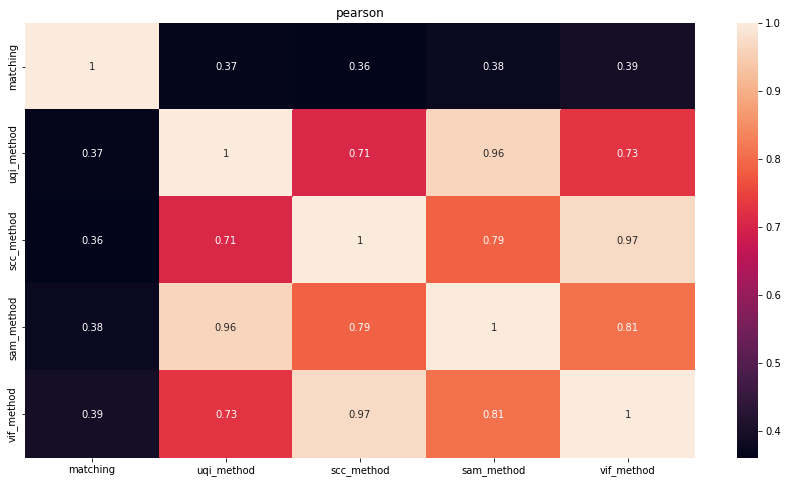

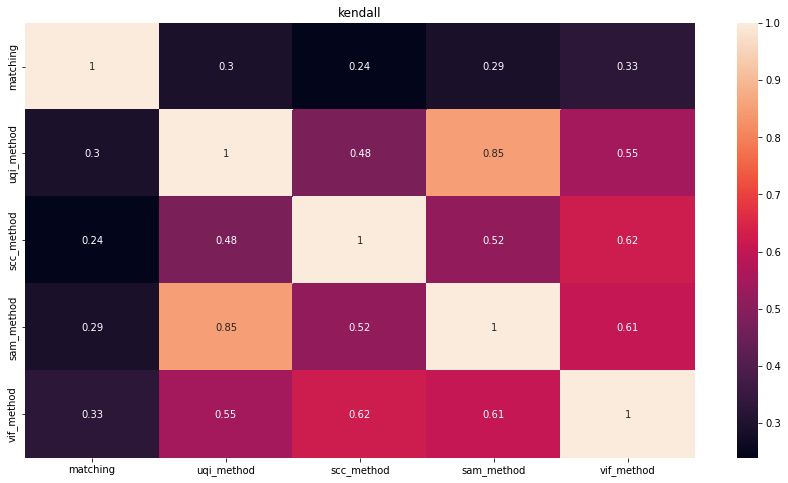

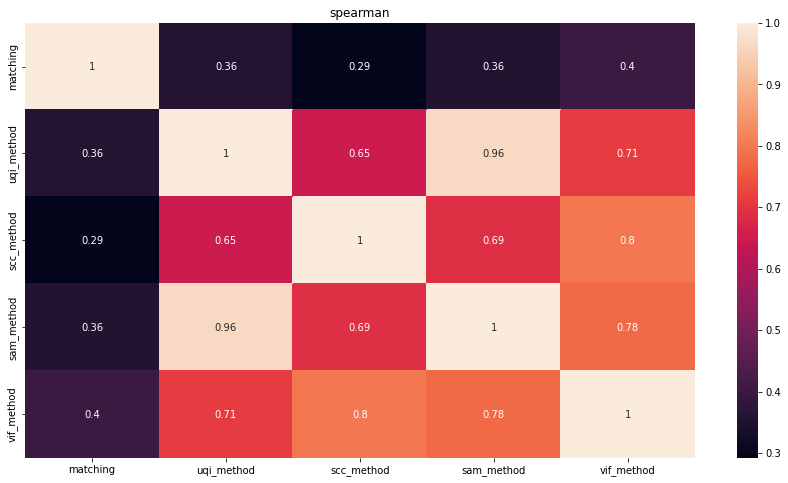

In [ ]:
metodos = {'uqi_method':uqi_method,
           'scc_method':scc_method,
           'sam_method':sam_method,
           'vif_method':vif_method}
train_correlation = train.drop(['title_1', 'title_2', 'price_1', 'price_2', 'image_1',
                               'image_2', 't_s_f_puro', 't_s_f_ratio', 't_s_f_token',
                               't_s_f_pr', 'simi_valor','tem_valor','tem_imagem'], axis=1)
print(train_correlation.columns)
#matriz de correlação
for metodo in ['pearson','kendall','spearman']:
    cor = train_correlation.corr(method=metodo)
    plt.figure(figsize = (15,8))
    plt.title(metodo)
    sns.heatmap(cor, annot = True)

In [ ]:
train.columns

Index(['title_1', 'title_2', 'price_1', 'price_2', 'image_1', 'image_2',
       'matching', 't_s_f_puro', 't_s_f_ratio', 't_s_f_token', 't_s_f_pr',
       'simi_valor', 'tem_valor', 'uqi_method', 'scc_method', 'sam_method',
       'vif_method', 'tem_imagem'],
      dtype='object')

In [ ]:
train.drop(['title_1', 'title_2', 'price_1', 'price_2', 'image_1','image_2'], axis=1,inplace=True)

In [ ]:
train.columns

Index(['matching', 't_s_f_puro', 't_s_f_ratio', 't_s_f_token', 't_s_f_pr',
       'simi_valor', 'tem_valor', 'uqi_method', 'scc_method', 'sam_method',
       'vif_method', 'tem_imagem'],
      dtype='object')

In [ ]:
train.head()

,matching,t_s_f_puro,t_s_f_ratio,t_s_f_token,t_s_f_pr,simi_valor,tem_valor,uqi_method,scc_method,sam_method,vif_method,tem_imagem
0,1,0.508475,0.51,0.51,0.50,0.844271,1,0.643183,0.013832,0.337003,0.011803,1
1,1,0.365854,0.37,0.37,0.69,0.810760,1,0.701960,0.017497,0.538539,0.056150,1
2,1,0.616667,0.48,0.48,0.66,1.000000,1,0.733706,0.188897,0.585262,0.214776,0
3,1,0.460526,0.25,0.25,0.41,0.832985,1,0.542859,-0.052532,0.251584,0.005156,1
4,1,0.945946,0.95,0.95,0.95,1.000000,1,0.737859,-0.000114,0.642040,0.121919,1


In [ ]:
for coluna in train.drop('matching',axis=1).columns:
    print(f'Valor máximo da coluna {coluna}: ',train[coluna].max())

Valor máximo da coluna t_s_f_puro:  1.0
Valor máximo da coluna t_s_f_ratio:  1.0
Valor máximo da coluna t_s_f_token:  1.0
Valor máximo da coluna t_s_f_pr:  1.0
Valor máximo da coluna simi_valor:  1.0
Valor máximo da coluna tem_valor:  1
Valor máximo da coluna uqi_method:  1.0
Valor máximo da coluna scc_method:  1.0
Valor máximo da coluna sam_method:  1.0
Valor máximo da coluna vif_method:  0.9999999999917756
Valor máximo da coluna tem_imagem:  1


#### Treinando modelo xgboost + optuna ( otimizador de hiperparametros )

In [ ]:
# Modelo - xgboost
def objective_xgboost(trial,scoring,n_jobs):
    X=train.loc[:, train.columns != 'matching']
    y=train['matching']
    
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    n_estimators = trial.suggest_int('n_estimators',100,400)
    max_depth = trial.suggest_int('max_depth',20,30)
    learning_rate = trial.suggest_float("learning_rate", 1e-1, 1)
    alpha = trial.suggest_float("alpha", 1, 10)
    booster = trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"])
    min_child_weight  = trial.suggest_int("min_child_weight ",1e-4,1e-2)
    reg_alpha = trial.suggest_float("reg_alpha",1e-1,2)
    reg_lambda = trial.suggest_int("reg_lambda",1,6)

    
    X, y =train.loc[:, train.columns != 'matching'],train['matching']
    xg_clf = xgb.XGBClassifier(objective="binary:logistic",
                               colsample_bytree = colsample_bytree,
                               learning_rate = learning_rate, 
                               max_depth = max_depth, 
                               alpha = alpha, 
                               n_estimators = n_estimators,
                               booster = booster ,
                               min_child_weight = min_child_weight,
                               reg_alpha = reg_alpha,
                               reg_lambda = reg_lambda,
                               random_state=42)

    #definição dos hiperparâmetros do pca e seus intervalos
    pca_params = {
                  'n_components':trial.suggest_int(name='n_components', low=2, high=X.shape[1])
                  ,'whiten': trial.suggest_categorical('whiten', [True, False, 'Deactivated']) #deactavated testa se fica melhor sem o PCA
                 }
    #configuração do PCA com os hiperparâmetros sugeridos pelo otimizador
    if pca_params['whiten'] != 'Deactivated':
        pca = PCA(**pca_params)

        #Aplicação do PCA nas colunas
        components = pca.fit_transform(X)
    else:
        components = X
    #Aplicação do lightBoost através de validação cruzada
    scores = cross_validate( xg_clf, components, y, cv=5, scoring=scoring, n_jobs=n_jobs)
    acc=scores[f'test_score'].mean()
    return acc

#Configuração do optuna para utilizar o otimizador TPESampler com seus parâmetros mais robustos
sampler = optuna.samplers.TPESampler(multivariate=True, group=True)
            
#Criação do estudo passando o otimizador como parâmetro e definindo como problema de otimização            
study = optuna.create_study(direction = 'maximize',sampler=sampler)

func = lambda trial: objective_xgboost(trial,scoring=('accuracy'), n_jobs=-1)
study.optimize(func,n_trials=200)

[I 2022-02-15 20:06:30,347] A new study created in memory with name: no-name-7c0acba8-36d3-4f8f-a12c-de19f94b08c1
[I 2022-02-15 20:06:31,984] Trial 0 finished with value: 0.5 and parameters: {'colsample_bytree': 0.8513274072604522, 'n_estimators': 360, 'max_depth': 23, 'learning_rate': 0.16766698444090175, 'alpha': 5.377842549744747, 'booster': 'gblinear', 'min_child_weight ': 0, 'reg_alpha': 1.8827574701666059, 'reg_lambda': 1, 'n_components': 7, 'whiten': True}. Best is trial 0 with value: 0.5.
[I 2022-02-15 20:06:32,254] Trial 1 finished with value: 0.7731707317073171 and parameters: {'colsample_bytree': 0.9020698903067781, 'n_estimators': 362, 'max_depth': 24, 'learning_rate': 0.4343337764902917, 'alpha': 1.8272380913647719, 'booster': 'gbtree', 'min_child_weight ': 0, 'reg_alpha': 1.898937723363384, 'reg_lambda': 5, 'n_components': 5, 'whiten': True}. Best is trial 1 with value: 0.7731707317073171.
[I 2022-02-15 20:06:32,647] Trial 2 finished with value: 0.7707317073170732 and par

In [ ]:
trial_xgboost = study.best_trial

In [ ]:
trial_xgboost.value

0.8073170731707318

In [ ]:
trial_xgboost.params

{'alpha': 8.77414601548518,
 'booster': 'gbtree',
 'colsample_bytree': 0.971121616540647,
 'learning_rate': 0.2026977324038498,
 'max_depth': 26,
 'min_child_weight ': 0,
 'n_components': 8,
 'n_estimators': 312,
 'reg_alpha': 1.125029189831152,
 'reg_lambda': 4,
 'whiten': 'Deactivated'}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

#### Montando o xgboost final com os melhores parâmetros encontrados

Acurácia: 0.8293
Sensitividade: 0.8780
Especificidade: 0.7805


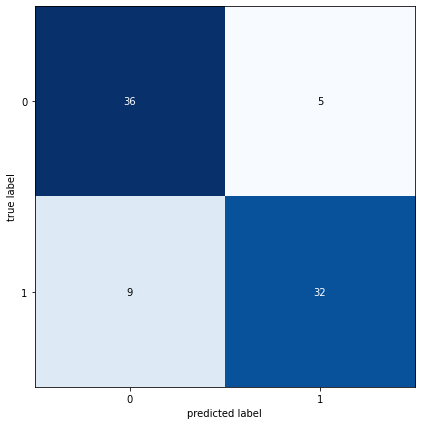

In [ ]:
X, y =train.loc[:, train.columns != 'matching'],train['matching']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
xg_clf = xgb.XGBClassifier(objective="binary:logistic",
                           colsample_bytree = trial_xgboost.params['colsample_bytree'],
                           learning_rate = trial_xgboost.params['learning_rate'], 
                           max_depth = trial_xgboost.params['max_depth'], 
                           alpha = trial_xgboost.params['alpha'], 
                           n_estimators = trial_xgboost.params['n_estimators'],
                           random_state=42,
                           eval_metric='mlogloss')
xg_clf.fit(X_train,y_train)
preds = xg_clf.predict(X_test)
acc = metrics.accuracy_score(y_test, preds)

cm = confusion_matrix(y_test,preds)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))



fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(7, 7))
plt.show()

In [ ]:
xboost_acc = acc

simi_valor     0.221475
t_s_f_puro     0.122016
t_s_f_pr       0.121546
t_s_f_ratio    0.092500
tem_imagem     0.084845
vif_method     0.079967
sam_method     0.077471
uqi_method     0.074095
scc_method     0.073429
t_s_f_token    0.052656
tem_valor      0.000000
dtype: float32


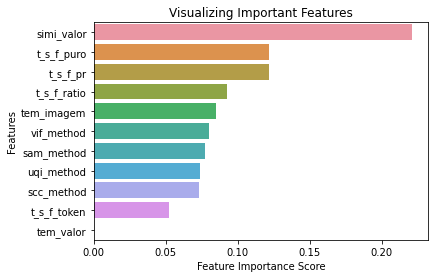

In [ ]:
feature_imp = pd.Series(xg_clf.feature_importances_,index=train.drop('matching',axis=1).columns).sort_values(ascending=False)
print(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

#### Treinando modelo light gradient + optuna ( otimizador de hiperparametros )

In [ ]:
# Modelo - Light Gradient Boosting 
def objective_lightboost(trial,scoring,n_jobs):
    X=train.loc[:, train.columns != 'matching']
    y=train['matching']
    
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.7, 1)
    n_estimators = trial.suggest_int('n_estimators',350,450)
    max_depth = trial.suggest_int('max_depth',15,30)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.4)
    alpha = trial.suggest_float("alpha", 5, 8)
    importance_type = trial.suggest_categorical("importance_type", ["split", "gain"])
    min_child_samples = trial.suggest_int("min_child_samples",25,35)
    min_child_weight = trial.suggest_float("min_child_weight",1e-4,1e-2)
    min_split_gain = trial.suggest_float("min_split_gain",1e-4,1)
    num_leaves = trial.suggest_int("num_leaves",20,30)
    reg_alpha = trial.suggest_float("reg_alpha",1e-1,2)
    reg_lambda = trial.suggest_int("reg_lambda",1,6)
    
    X, y =train.loc[:, train.columns != 'matching'],train['matching']
    
    lgbclf = lgb.LGBMClassifier(max_depth=max_depth,
                                learning_rate=learning_rate,
                                colsample_bytree=colsample_bytree,
                                n_estimators=n_estimators,
                                alpha=alpha,
                                importance_type=importance_type,
                                min_child_samples=min_child_samples,
                                min_child_weight=min_child_weight,
                                min_split_gain=min_split_gain,
                                num_leaves=num_leaves,
                                reg_alpha=reg_alpha,
                                reg_lambda = reg_lambda,
                                n_jobs=-1) 
    
   #definição dos hiperparâmetros do pca e seus intervalos
    pca_params = {
                  'n_components':trial.suggest_int(name='n_components', low=2, high=X.shape[1])
                  ,'whiten': trial.suggest_categorical('whiten', [True, False, 'Deactivated']) #deactavated testa se fica melhor sem o PCA
                 }
    #configuração do PCA com os hiperparâmetros sugeridos pelo otimizador
    if pca_params['whiten'] != 'Deactivated':
        pca = PCA(**pca_params)
        #Aplicação do PCA nas colunas
        components = pca.fit_transform(X)
    else:
        components = X
    #Aplicação do lightBoost através de validação cruzada
    scores = cross_validate( lgbclf, components, y, cv=5, scoring=scoring, n_jobs=n_jobs)
    acc=scores[f'test_score'].mean()
    return acc

#Configuração do optuna para utilizar o otimizador TPESampler com seus parâmetros mais robustos
sampler = optuna.samplers.TPESampler(multivariate=True, group=True)
           
#Criação do estudo passando o otimizador como parâmetro e definindo como problema de otimização            
study = optuna.create_study(direction = 'maximize',sampler=sampler)

func = lambda trial: objective_lightboost(trial,scoring=('accuracy'), n_jobs=-1)
study.optimize(func,n_trials=1000)

[I 2022-02-15 20:09:44,076] A new study created in memory with name: no-name-e7e5616a-70ee-4bb0-9e8c-5f2458d82e3f
[I 2022-02-15 20:09:44,505] Trial 0 finished with value: 0.7804878048780488 and parameters: {'colsample_bytree': 0.9424475491147363, 'n_estimators': 434, 'max_depth': 20, 'learning_rate': 0.0415804541087121, 'alpha': 5.5708984890262165, 'importance_type': 'gain', 'min_child_samples': 27, 'min_child_weight': 0.009110414981025213, 'min_split_gain': 0.5101219540574546, 'num_leaves': 28, 'reg_alpha': 1.4051320432567538, 'reg_lambda': 4, 'n_components': 8, 'whiten': 'Deactivated'}. Best is trial 0 with value: 0.7804878048780488.
[I 2022-02-15 20:09:44,646] Trial 1 finished with value: 0.7365853658536585 and parameters: {'colsample_bytree': 0.9380328425341249, 'n_estimators': 405, 'max_depth': 26, 'learning_rate': 0.18726054503761594, 'alpha': 5.049069591390246, 'importance_type': 'split', 'min_child_samples': 27, 'min_child_weight': 0.007382544527898991, 'min_split_gain': 0.8472

In [ ]:
trial_lightboost = study.best_trial

In [ ]:
trial_lightboost.value

0.8048780487804879

In [ ]:
trial_lightboost.params

{'alpha': 7.146677563737383,
 'colsample_bytree': 0.7409000004607913,
 'importance_type': 'split',
 'learning_rate': 0.25539802420095226,
 'max_depth': 16,
 'min_child_samples': 29,
 'min_child_weight': 0.004664082239403904,
 'min_split_gain': 0.1536012921006758,
 'n_components': 10,
 'n_estimators': 420,
 'num_leaves': 29,
 'reg_alpha': 1.016125503641811,
 'reg_lambda': 3,
 'whiten': 'Deactivated'}

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

#### Montando o light gradient final com os melhores parâmetros encontrados

Acurácia: 0.8293
Sensitividade: 0.8537
Especificidade: 0.8049


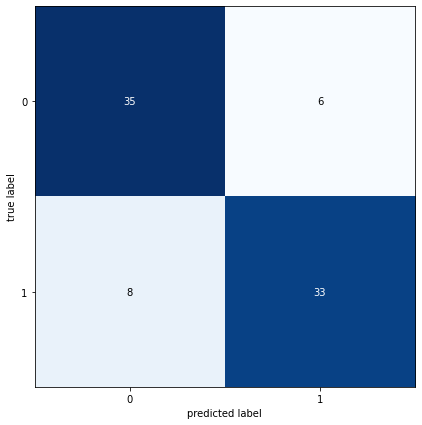

In [ ]:
X, y =train.loc[:, train.columns != 'matching'],train['matching']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)
    
lgbclf = lgb.LGBMClassifier(max_depth=trial_lightboost.params['max_depth'],
                            learning_rate=trial_lightboost.params['learning_rate'],
                            colsample_bytree=trial_lightboost.params['colsample_bytree'],
                            n_estimators=trial_lightboost.params['n_estimators'],
                            alpha=trial_lightboost.params['alpha'],
                            importance_type=trial_lightboost.params['importance_type'],
                            min_child_samples=trial_lightboost.params['min_child_samples'],
                            min_child_weight=trial_lightboost.params['min_child_weight'],
                            min_split_gain=trial_lightboost.params['min_split_gain'],
                            num_leaves=trial_lightboost.params['num_leaves'],
                            reg_alpha=trial_lightboost.params['reg_alpha'],
                            reg_lambda=trial_lightboost.params['reg_lambda'],
                            n_jobs=-1)

lgbclf.fit(X_train,y_train)
preds = lgbclf.predict(X_test)
acc = metrics.accuracy_score(y_test, preds)

cm = confusion_matrix(y_test,preds)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print("Acurácia: {:.4f}".format(acc))
print("Sensitividade: {:.4f}".format(sensitivity))
print("Especificidade: {:.4f}".format(specificity))



fig, ax = plot_confusion_matrix(conf_mat=cm ,  figsize=(7, 7))
plt.show()

In [ ]:
light_acc = acc

t_s_f_puro     49
simi_valor     49
t_s_f_pr       37
sam_method     29
vif_method     27
uqi_method     25
scc_method     18
t_s_f_token    11
t_s_f_ratio     7
tem_valor       0
tem_imagem      0
dtype: int64


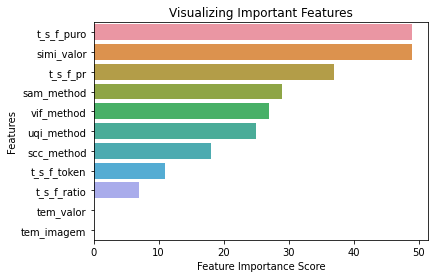

In [ ]:
feature_imp = pd.Series(lgbclf.feature_importances_,index=train.drop('matching',axis=1).columns).sort_values(ascending=False)
print(feature_imp)
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Verificando qual modelo obteve melhor acurácia e selecionando-o

In [ ]:
if light_acc > xboost_acc:
    model = lgbclf
else:
    model = xg_clf # Caso dê igual, seleciona o xgboost pois já é mais usual de se utilizar

## Salvando ( e carregando também ) o melhor modelo encontrado

In [ ]:
# save model to file
pickle.dump(model, open("best.pickle.dat", "wb"))

In [ ]:
# load model from file
model = pickle.load(open("best.pickle.dat", "rb"))

In [ ]:
model

XGBClassifier(alpha=8.77414601548518, colsample_bytree=0.971121616540647,
              eval_metric='mlogloss', learning_rate=0.2026977324038498,
              max_depth=26, missing=nan, n_estimators=312, random_state=42)

## Carregando a base de teste

In [ ]:
# Ingestão
test = pd.read_csv('/content/drive/MyDrive/data_set_meliuz/Cópia de test.csv')
#test = pd.read_csv(r'C:/Users/U11029/Downloads/Cópia de test.csv')

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id_1     158 non-null    object
 1   id_2     158 non-null    object
 2   title_1  158 non-null    object
 3   title_2  158 non-null    object
 4   price_1  158 non-null    int64 
 5   price_2  158 non-null    int64 
 6   image_1  158 non-null    object
 7   image_2  158 non-null    object
dtypes: int64(2), object(6)
memory usage: 10.0+ KB


In [ ]:
test.columns

Index(['id_1', 'id_2', 'title_1', 'title_2', 'price_1', 'price_2', 'image_1',
       'image_2'],
      dtype='object')

## Aplicando os geradores de métricas de texto, valor e imagem anteriormente utilizados

In [ ]:
# métricas de títulos
l_puro = []
l_ratio = []
l_token = []
l_pr = []
for linha in tqdm(range(len(test))):
    t1 = str(test['title_1'][linha]).replace('Usado:','').replace('Desbloqueado','').replace(',','').replace('(PRODUCT)','').replace('- Trocafone','').replace('Celular','').replace('Smartphone','').replace('.','').replace(' ','').lower()
    t1 = strip_accents(t1)
    t1 = remove_non_latin(t1)
    
    t2 = str(test['title_2'][linha]).replace('Usado:','').replace('Desbloqueado','').replace(',','').replace('(PRODUCT)','').replace('- Trocafone','').replace('Celular','').replace('Smartphone','').replace('.','').replace(' ','').lower()
    t2 = strip_accents(t2)
    t2 = remove_non_latin(t2)
    # print('--->>>SIMILARIDADE:',similaridade,'\n',t1,'\n',t2,'\n')

    # Hamming Distance
    # não é proveitoso pois as strings precisam ser principalmente do mesmo tamanho
    # similaridade = distance.hamming(list(t1),list(t2))

    # levenshtein puro
    l_puro.append(levenshtein_ratio_and_distance(t1,t2,ratio_calc = True))

    # igual a levenshtein, mas com menos casas decimais, pois é da lib fuzzywuzzy
    l_ratio.append(fuzz.ratio(t1,t2)/100)

    # Lida com casos em que as palavras estejam
    # em ordens diferentes, ele não será afetado
    l_token.append(fuzz.token_sort_ratio(t1,t2)/100)

    # Lida melhor pois considera substrings, ou seja, não é vítima de string de 
    # tamnhos muito divergentes
    l_pr.append(fuzz.partial_ratio(t1,t2)/100 )
test['t_s_f_puro'] = l_puro
test['t_s_f_ratio'] = l_ratio
test['t_s_f_token'] = l_token
test['t_s_f_pr'] = l_pr

100%|██████████| 158/158 [00:01<00:00, 118.06it/s]


In [ ]:
# Preços
similaridade_valor = []
tem_valor = []
for linha in tqdm(range(len(test))):
    v1 = test['price_1'][linha]
    v2 = test['price_2'][linha]
    if v1 == 0 or v2 == 0:
        tem_valor.append(0)
    else:
        tem_valor.append(1)
    if v1>=v2:
        similaridade = v2/v1
    elif v1<=v2:
        similaridade = v1/v2 
    else:
        similaridade = 0.5
    similaridade_valor.append(similaridade)
    #print('--->>>SIMILARIDADE:',similaridade,'\n',v1,'\n',v2,'\n')
test['simi_valor'] = similaridade_valor
test['tem_valor'] = tem_valor

100%|██████████| 158/158 [00:00<00:00, 37466.08it/s]


In [ ]:
# Métrica de imagens

imagens = []
for linha in tqdm(range(len(test))):
    #sleep(0.1)
    current_imgs = []
    try:
        resp1 = urllib.request.urlopen(test['image_1'][linha])
        img1 = np.asarray(bytearray(resp1.read()), dtype="uint8")
        img1 = cv2.imdecode(img1, cv2.IMREAD_COLOR)
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        current_imgs.append(img1)
    except:
        current_imgs.append('no_image')
    try:
        resp2 = urllib.request.urlopen(test['image_2'][linha])
        img2 = np.asarray(bytearray(resp2.read()), dtype="uint8")
        img2 = cv2.imdecode(img2, cv2.IMREAD_COLOR)
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        current_imgs.append(img2)
    except:
        current_imgs.append('no_image')
    imagens.append(current_imgs)   
    
    
uqi_method = []
scc_method = []
sam_method = []
vif_method = []
tem_imagem = []
for imagem in tqdm(range(len(imagens))):
    img1 = imagens[imagem][0]
    img2 = imagens[imagem][1]
    if 'no_image' in [img1,img2]:
        # médias das métricas ao analisar casos não-inválidos
        uqi_method.append(0.7337058483410432)
        scc_method.append(0.18889738818915006)
        sam_method.append(0.585261690732141)
        vif_method.append(0.21477629163645973)
        tem_imagem.append(0)
        continue     
    uqi_method.append(uqi(img1, img2))
    scc_method.append(scc(img1, img2))
    sam_method.append(1-sam(img1, img2))
    vif_method.append(vifp(img1, img2))
    tem_imagem.append(1)
    
    
test['uqi_method'] = uqi_method
test['scc_method'] = scc_method
test['sam_method'] = sam_method
test['vif_method'] = vif_method
test['tem_imagem'] = tem_imagem

100%|██████████| 158/158 [00:40<00:00,  3.86it/s]


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158 entries, 0 to 157
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_1         158 non-null    object 
 1   id_2         158 non-null    object 
 2   title_1      158 non-null    object 
 3   title_2      158 non-null    object 
 4   price_1      158 non-null    int64  
 5   price_2      158 non-null    int64  
 6   image_1      158 non-null    object 
 7   image_2      158 non-null    object 
 8   t_s_f_puro   158 non-null    float64
 9   t_s_f_ratio  158 non-null    float64
 10  t_s_f_token  158 non-null    float64
 11  t_s_f_pr     158 non-null    float64
 12  simi_valor   158 non-null    float64
 13  tem_valor    158 non-null    int64  
 14  uqi_method   158 non-null    float64
 15  scc_method   158 non-null    float64
 16  sam_method   158 non-null    float64
 17  vif_method   158 non-null    float64
 18  tem_imagem   158 non-null    int64  
dtypes: float

## Realizando as predições em cima do dataset de teste

In [ ]:
preds = model.predict(test.drop(['id_1', 'id_2','title_1', 'title_2', 'price_1', 'price_2', 'image_1','image_2'], axis=1))

In [ ]:
test = test[['id_1', 'id_2']]
test.head()

,id_1,id_2
0,a820b47d84bca92fad99cad0d8a2a6de,4b3b40526f8e6086b482165fcf762bf1
1,ece2e2e22f5ca27fd306056c93ca9484,edd4a4b222c591ccb4be6c0960fd816f
2,cc8de55a71f044a2aeb3a29d9eb792f7,500b4ec301ab46a85f874a81795bcc91
3,1a09b082aa45bf6e27d09456d932984a,75a59622328ab9c175cc2339ea3ef74d
4,fb4db7d25f103ce6eff377d527bce8cd,85c79228f0a6fa3c61fc4d0a554024eb


In [ ]:
test['matching'] = list(preds)
test.head()

,id_1,id_2,matching
0,a820b47d84bca92fad99cad0d8a2a6de,4b3b40526f8e6086b482165fcf762bf1,1
1,ece2e2e22f5ca27fd306056c93ca9484,edd4a4b222c591ccb4be6c0960fd816f,1
2,cc8de55a71f044a2aeb3a29d9eb792f7,500b4ec301ab46a85f874a81795bcc91,1
3,1a09b082aa45bf6e27d09456d932984a,75a59622328ab9c175cc2339ea3ef74d,1
4,fb4db7d25f103ce6eff377d527bce8cd,85c79228f0a6fa3c61fc4d0a554024eb,0


## Salvando as previsões

In [ ]:
test.to_csv('predictions_matching_Joao_Francisco_Vieira_Rodrigues_Filho.csv', index = False)

In [ ]:
model

XGBClassifier(alpha=8.77414601548518, colsample_bytree=0.971121616540647,
              eval_metric='mlogloss', learning_rate=0.2026977324038498,
              max_depth=26, missing=nan, n_estimators=312, random_state=42)